## Imports

In [1]:
from __future__ import annotations

import csv, os, re
from pathlib import Path
from typing import Tuple, Sequence

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import TransformerConv, global_mean_pool

from rdkit import Chem
from rdkit.Chem import rdChemReactions
from joblib import Parallel, delayed
import tqdm.auto as tqdm

/home/localadmin/Retrosynthesis/3.9venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Feature Extraction Utils

In [2]:
_SYMBOLS = [
    'C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br', 'Li', 'Na', 'K',
    'Mg', 'B', 'Sn', 'I', 'Se', 'unk'
]
_SYMBOL_TO_IDX = {s: i for i, s in enumerate(_SYMBOLS)}
_BOND_TYPES = [
    Chem.rdchem.BondType.SINGLE,
    Chem.rdchem.BondType.DOUBLE,
    Chem.rdchem.BondType.TRIPLE,
    Chem.rdchem.BondType.AROMATIC,
]
_BOND_TO_IDX = {b: i for i, b in enumerate(_BOND_TYPES)}


def _one_hot(idx: int, dim: int) -> torch.Tensor:
    v = torch.zeros(dim); v[idx] = 1.0; return v


def atom_features(a: Chem.Atom) -> torch.Tensor:
    return torch.cat([
        _one_hot(_SYMBOL_TO_IDX.get(a.GetSymbol(), _SYMBOL_TO_IDX['unk']), len(_SYMBOLS)),
        torch.tensor([
            a.GetFormalCharge(), a.GetTotalDegree(), a.GetTotalNumHs(),
            a.GetTotalValence(), float(a.GetIsAromatic()), float(a.IsInRing())
        ])
    ])


def bond_features(b: Chem.Bond) -> torch.Tensor:
    return torch.cat([
        _one_hot(_BOND_TO_IDX[b.GetBondType()], len(_BOND_TYPES)),
        torch.tensor([float(b.GetIsConjugated()), float(b.IsInRing())])
    ])

## Graph Conversion Utilities

In [ ]:
def _bonds_to_break(rcts: Sequence[Chem.Mol], prod: Chem.Mol):
    r, p = set(), set()
    for m in rcts:
        for b in m.GetBonds():
            a1, a2 = b.GetBeginAtom().GetAtomMapNum(), b.GetEndAtom().GetAtomMapNum()
            if a1 and a2: r.add(tuple(sorted((a1, a2))))
    for b in prod.GetBonds():
        a1, a2 = b.GetBeginAtom().GetAtomMapNum(), b.GetEndAtom().GetAtomMapNum()
        if a1 and a2: p.add(tuple(sorted((a1, a2))))
    return p - r


def _pair_to_graph(pair: Tuple[Sequence[Chem.Mol], Chem.Mol]):
    rcts, prod = pair
    x = torch.stack([atom_features(at) for at in prod.GetAtoms()])

    # mapping for fast lookup (skip mapNum == 0)
    map2idx = {a.GetAtomMapNum(): a.GetIdx() for a in prod.GetAtoms() if a.GetAtomMapNum()}
    break_idx = {tuple(sorted((map2idx[m1], map2idx[m2]))) for m1, m2 in _bonds_to_break(rcts, prod) if m1 in map2idx and m2 in map2idx}

    ei, ea, el = [], [], []
    for b in prod.GetBonds():
        i, j = b.GetBeginAtomIdx(), b.GetEndAtomIdx()
        feat = bond_features(b)
        lbl = 1 if tuple(sorted((i, j))) in break_idx else 0
        for u, v in ((i, j), (j, i)):
            ei.append([u, v]); ea.append(feat); el.append(lbl)

    return Data(
        x=x,
        edge_index=torch.tensor(ei, dtype=torch.long).t().contiguous(),
        edge_attr=torch.stack(ea),
        y=torch.tensor(el, dtype=torch.float).view(-1, 1)
    )


## Data parsing function

In [4]:
def _row_to_pair(row):
    """Convert a CSV row to (reactant mols, product mol) or return None."""
    try:
        left, right = row['rxnSmiles_Mapping_NameRxn'].split('>>')
        idx = [int(i) for i in re.findall(r'\d+', row['reactantSet_NameRxn'])]
        rcts = [left.split('.')[i] for i in idx]
        prods = right.split('.')
        if len(prods) != 1:
            return None
        r_mols = [Chem.MolFromSmiles(s) for s in rcts]
        p_mol = Chem.MolFromSmiles(prods[0])
        rxn = rdChemReactions.ChemicalReaction(); [rxn.AddReactantTemplate(m) for m in r_mols]; rxn.AddProductTemplate(p_mol)
        if rxn.Validate()[1]:
            return None
        return r_mols, p_mol
    except Exception:
        return None

## Dataset Class

In [5]:
class CentreDataset(InMemoryDataset):
    def __init__(self, csv_path: str, jobs: int):
        self.csv_path, self.jobs = csv_path, jobs
        super().__init__(root=Path(csv_path).parent)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def processed_file_names(self):
        return ["centre_data.pt"]

    # ----- heavy I/O and RDKit in parallel -----
    def _parse_pairs(self):
        rows = list(csv.DictReader(open(self.csv_path)))
        print(f"CSV rows: {len(rows)} — RDKit parsing on {self.jobs} processes …")
        pairs = Parallel(n_jobs=self.jobs)(delayed(_row_to_pair)(r) for r in rows)
        return [p for p in pairs if p]

    def process(self):
        pairs = self._parse_pairs()
        print(f"Mol-pairs: {len(pairs)} — graph build on {self.jobs} threads …")
        graphs = Parallel(n_jobs=self.jobs, backend="multiprocessing", batch_size=128)(
            delayed(_pair_to_graph)(p) for p in tqdm.tqdm(pairs, desc="graphs")
        )
        pos = sum(int(g.y.sum()) for g in graphs)
        tot = sum(int(g.y.numel()) for g in graphs)
        print(f"Positive edge ratio = {pos/tot:.2%}")
        data, slices = self.collate(graphs)
        Path(self.processed_dir).mkdir(parents=True, exist_ok=True)
        torch.save((data, slices), self.processed_paths[0])

## Training

In [ ]:
EPOCHS = 25

device = "cuda" if torch.cuda.is_available() else "cpu"
ds = CentreDataset('data/dataSetB.csv', os.cpu_count())

n_tr, n_val = int(0.8 * len(ds)), int(0.1 * len(ds))
# train_ds, val_ds, test_ds = torch.utils.data.(ds, [n_tr, n_val, len(ds) - n_tr - n_val])

train_size = int(0.8 * len(ds))
val_size = int(0.1 * len(ds))
test_size = len(ds) - train_size - val_size

train_ds = ds[:train_size]
val_ds = ds[train_size : train_size + val_size]
test_ds = ds[train_size + val_size :]

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64)
test_loader  = DataLoader(test_ds, batch_size=64)

hidden = 128
model = GNN(ds.num_node_features, ds.num_edge_features, hidden=hidden).to(device)

pos = sum(int(d.y.sum()) for d in ds)
neg = sum(int(d.y.numel() - d.y.sum()) for d in ds)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([neg/pos], device=device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [16]:
best_auc = 0.0
for epoch in tqdm.tqdm(range(1, EPOCHS + 1)):
    tr_loss = _run_epoch(model, train_loader, criterion, opt=optimizer, device=device)
    val_loss, val_auc = _run_epoch(model, val_loader, criterion, device=device)
    print(f"Ep{epoch:02d}: train {tr_loss:.4f}  val {val_loss:.4f}  AUC {val_auc:.3f}")
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), "best_model.pt")

  4%|▍         | 1/25 [00:18<07:21, 18.40s/it]

Ep01: train 1.0945  val 0.9007  AUC 0.870


  8%|▊         | 2/25 [00:31<05:57, 15.52s/it]

Ep02: train 0.8471  val 0.7598  AUC 0.909


 12%|█▏        | 3/25 [00:44<05:15, 14.36s/it]

Ep03: train 0.7644  val 0.7020  AUC 0.921


 16%|█▌        | 4/25 [00:57<04:50, 13.83s/it]

Ep04: train 0.7228  val 0.6679  AUC 0.928


 20%|██        | 5/25 [01:09<04:23, 13.19s/it]

Ep05: train 0.6958  val 0.6451  AUC 0.932


 24%|██▍       | 6/25 [01:23<04:11, 13.22s/it]

Ep06: train 0.6770  val 0.6264  AUC 0.935


 28%|██▊       | 7/25 [01:36<03:57, 13.20s/it]

Ep07: train 0.6605  val 0.6123  AUC 0.938


 32%|███▏      | 8/25 [01:49<03:43, 13.17s/it]

Ep08: train 0.6482  val 0.6026  AUC 0.940


 36%|███▌      | 9/25 [02:02<03:30, 13.18s/it]

Ep09: train 0.6360  val 0.5910  AUC 0.942


 40%|████      | 10/25 [02:16<03:19, 13.27s/it]

Ep10: train 0.6277  val 0.5830  AUC 0.943


 44%|████▍     | 11/25 [02:29<03:06, 13.29s/it]

Ep11: train 0.6185  val 0.5753  AUC 0.945


 48%|████▊     | 12/25 [02:42<02:53, 13.31s/it]

Ep12: train 0.6099  val 0.5681  AUC 0.946


 52%|█████▏    | 13/25 [02:56<02:39, 13.27s/it]

Ep13: train 0.6022  val 0.5617  AUC 0.947


 56%|█████▌    | 14/25 [03:06<02:18, 12.56s/it]

Ep14: train 0.5958  val 0.5553  AUC 0.948


 60%|██████    | 15/25 [03:18<02:02, 12.24s/it]

Ep15: train 0.5899  val 0.5501  AUC 0.949


 64%|██████▍   | 16/25 [03:29<01:46, 11.85s/it]

Ep16: train 0.5851  val 0.5449  AUC 0.950


 68%|██████▊   | 17/25 [03:41<01:34, 11.80s/it]

Ep17: train 0.5795  val 0.5404  AUC 0.951


 72%|███████▏  | 18/25 [03:53<01:23, 11.99s/it]

Ep18: train 0.5747  val 0.5382  AUC 0.951


 76%|███████▌  | 19/25 [04:06<01:14, 12.40s/it]

Ep19: train 0.5696  val 0.5329  AUC 0.952


 80%|████████  | 20/25 [04:19<01:02, 12.55s/it]

Ep20: train 0.5658  val 0.5296  AUC 0.952


 84%|████████▍ | 21/25 [04:32<00:50, 12.65s/it]

Ep21: train 0.5629  val 0.5268  AUC 0.953


 88%|████████▊ | 22/25 [04:45<00:38, 12.77s/it]

Ep22: train 0.5591  val 0.5218  AUC 0.953


 92%|█████████▏| 23/25 [04:58<00:25, 12.85s/it]

Ep23: train 0.5558  val 0.5223  AUC 0.954


 96%|█████████▌| 24/25 [05:11<00:12, 12.92s/it]

Ep24: train 0.5505  val 0.5156  AUC 0.954


100%|██████████| 25/25 [05:25<00:00, 13.02s/it]

Ep25: train 0.5500  val 0.5166  AUC 0.955


## Evaluation

Test AUC = 0.954

Precision / recall / F1 on test bonds:
              precision    recall  f1-score   support

         0.0      0.998     0.858     0.922    131076
         1.0      0.152     0.925     0.261      3605

    accuracy                          0.859    134681
   macro avg      0.575     0.891     0.591    134681
weighted avg      0.975     0.859     0.905    134681



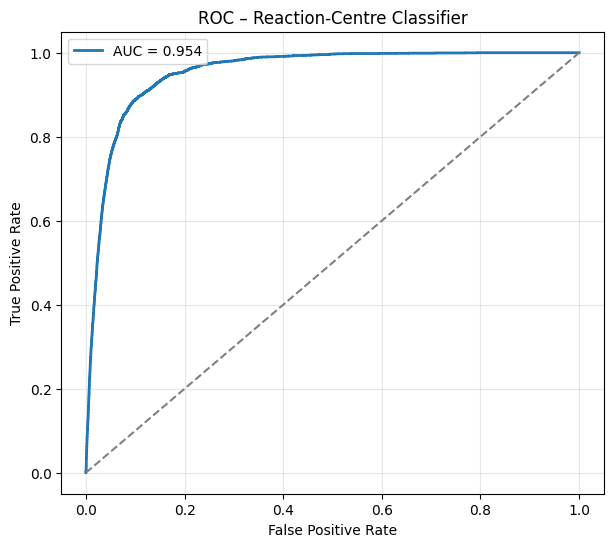

In [17]:
# model = GNN(ds.num_node_features, ds.num_edge_features, hidden=hidden).to(device)
# model.load_state_dict(torch.load("best_model_best.pt"))
_, test_auc = _run_epoch(model, test_loader, criterion, device=device)
print(f"Test AUC = {test_auc:.3f}")


import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve
probs, y_true = _collect_preds(model, test_loader, device)
y_pred = (probs > 0.5).int()  # threshold can be tuned

print("\nPrecision / recall / F1 on test bonds:")
print(classification_report(y_true.numpy(), y_pred.numpy(), digits=3))

fpr, tpr, _ = roc_curve(y_true.numpy(), probs.numpy())
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {test_auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="grey")
plt.xlabel("False Positive Rate");  plt.ylabel("True Positive Rate")
plt.title("ROC – Reaction-Centre Classifier");  plt.legend();  plt.grid(alpha=.3)
plt.show()